<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/11_Feature_learning/11_1_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 11.1 Introduction

In Chapter 10 we saw how supervised and unsupervised learners alike can be extended to perform nonlinear learning via the use of nonlinear functions (or feature transformations) that we engineered ourselves by visually examining data. For example, we
expressed a general nonlinear model for regression and two-class
classification as a weighted sum of $B$ nonlinear functions of our
input as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\label{equation:general-model-chapter-11-intro}
\end{equation}

where $f_1$ through $f_B$ are nonlinear parameterized or
unparameterized functions (or features) of the data, and $w_0$ through $w_B$ (along
with any additional weights internal to the nonlinear functions) are
represented in the weight set $\Theta$. 

In this Chapter we detail the fundamental tools and principles of *feature learning* (or *automatic feature engineering*) that allow us to automate this task and *learn* proper features from the data itself, instead of \emph{engineering} them ourselves.  In particular we discuss how to choose the form of the nonlinear transformations $f_1$ through $f_B$, the number $B$ of them employed, as well as, how the parameters in $\Theta$ are tuned, *automatically* and for *any dataset*.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone images
if not Path('chapter_11_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/11_Feature_learning/chapter_11_images
else:
    print('chapter_11_images already cloned!')

# image paths
image_path_1 = "chapter_11_images/Figure_11_1.png"
image_path_2 = "chapter_11_images/Figure_11_2.png"

# standard imports
import matplotlib.pyplot as plt
import IPython, copy
from IPython.display import Image, HTML
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_11_images already cloned!


## The limits of nonlinear feature engineering

As we have described in previous Chapters, *features* are those
defining characteristics of a given dataset that allow for optimal
learning.  In Chapter 10 we saw how the quality of the mathematical features we can design ourselves is fundamentally dependent on our level of knowledge regarding the phenomenon we were studying. The more we understand (both intellectually and intuitively) the process generating the data we have at our fingertips, the better we can design features ourselves.  At one extreme where we have near perfect understanding of the process generating our data, this knowledge having come from considerable intuitive, experimental, and mathematical reflection, the features we design allow near perfect performance. However, more often than not we know only a few facts, or perhaps none at all, about
the data we are analyzing.   The universe is an enormous and complicated
place, and we have a solid understanding only of how a sliver of it all  works. 

Most (particularly modern) machine learning datasets have far more than two inputs, rendering visualization useless as a tool for feature engineering. But even in rare cases where data visualization is possible, we cannot simply rely on our own pattern recognition skills. Take the two toy datasets illustrated in [Figure 11.1](#figure-11-1) below, for example. The dataset on the left is a regression dataset with $N=1$ dimensional input and the one on the right is a two-class classification dataset with $N=2$ dimensional input. The true underlying nonlinear model used to generate the data in each case is shown in dashed black. We humans are typically taught only how to recognize the simplest of nonlinear patterns *by eye*, including those created by elementary functions (e.g., low degree polynomials, exponential functions, sine waves) and simple shapes (e.g., squares, circles, ellipses). Neither of the patterns shown in the Figure match such simple nonlinear functionalities. Thus, whether or not a dataset can be visualized, human engineering of proper nonlinear features can be difficult if not outright impossible.

---

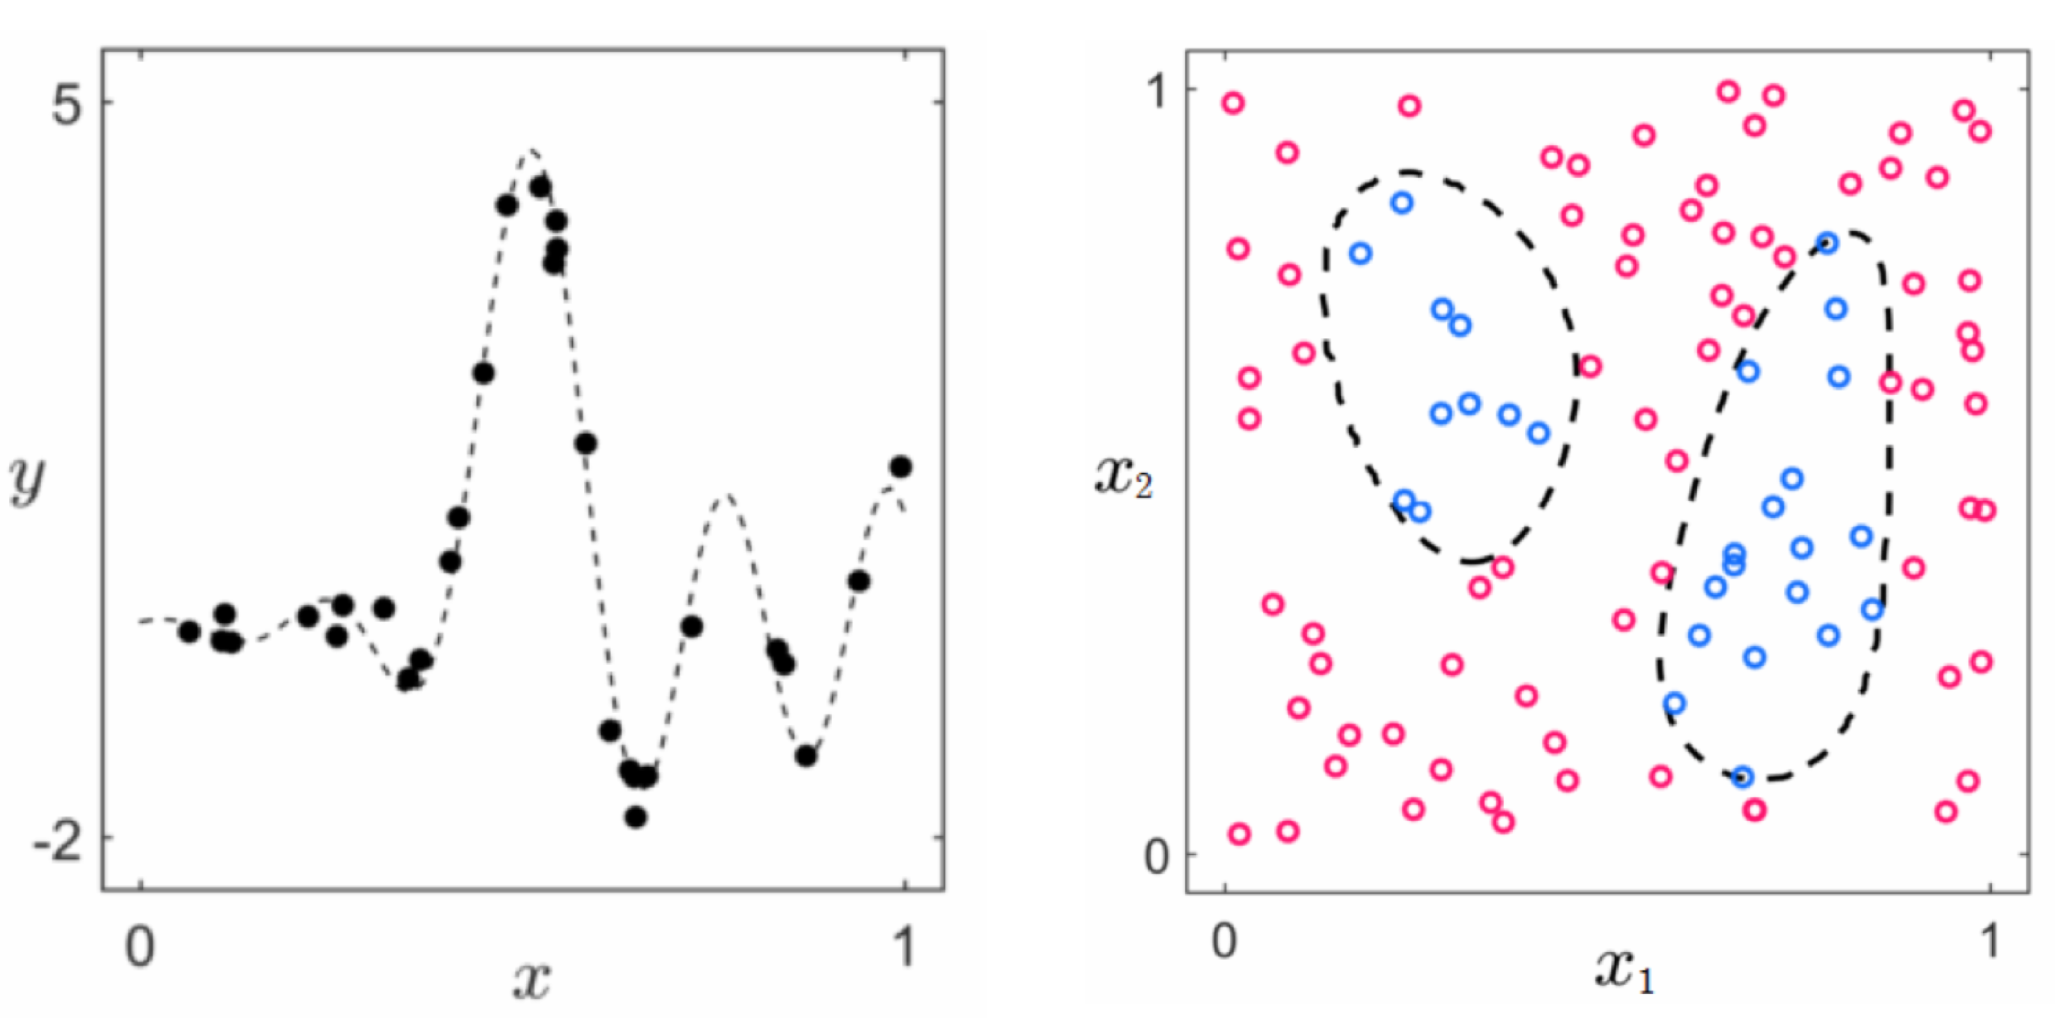

In [2]:
Image(image_path_1)

<a id='figure-11-1'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.1 </strong> <em> 
Toy (left panel) regression and (right panel) two-class classification datasets that clearly exhibit nonlinear behavior. The true underlying nonlinear function used to generate the data in each case is shown in dashed black. See text for further details
</em>
</figcaption>
</figure>

---

It is precisely this challenge which motivates the fundamental
*feature learning* tools described in this Chapter. In short, these technologies *automate* the process of identifying appropriate nonlinear features for arbitrary datasets. With these tools in hand we no longer need to *engineer* proper nonlinearities, at least in terms of how we engineered nonlinear features in the previous Chapter. Instead, we aim at *learning* their appropriate forms. Compared to our own limited nonlinear pattern recognition abilities, feature learning tools can identify virtually any
nonlinear pattern present in a dataset regardless of its input dimension.

## Chapter outline

The aim to automate nonlinear learning is an ambitious one and perhaps at first glance an intimidating one as well, for there are an infinite variety of nonlinearities and nonlinear functions to choose from. How do we, in general, parse this infinitude automatically to determine the appropriate nonlinearity for a given dataset?

The first step, as we will see in [Section 11.2](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_2_Universal.html), is to organize the pursuit of automation by first placing the fundamental building blocks of this infinitude into *manageable collections* of (relatively simple) nonlinear functions. These collections are often called *universal approximators*, of which three strains are popularly used and which we introduce here: fixed-shape approximators, artificial neural networks, and trees. After introducing universal approximators we then discuss the fundamental concepts underlying how they are employed, including the necessity for *validation error* as a measurement tool in [Section 11.3](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_3_Real_approximation.html), a description of *cross-validation* and the *bias-variance tradeoff* in [Section 11.4](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_4_Cross_validation.html), the automatic tuning of nonlinear complexity via *boosting* and *regularization* in Sections [11.5](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_5_Boosting.html) and [11.6](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_6_Regularization.html), respectively, as well as the notion of *ensembling* or *bagging* in [Section 11.9](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_9_Bagging.html) and *K-folds cross-validation* in [Section 11.10](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_10_Kfolds.html).

## The complexity dial metaphor of feature learning

The ultimate aim of feature learning is a paradigm for the appropriate and automatic learning of features for any \emph{any dataset} regardless of problem type.  This translates - formally speaking - into the the automatic determination of both the proper *form* of the general nonlinear model in Equation (1) above and the proper *parameter tuning* of this model regardless of training data and problem type.  We can think about this challenge metaphorically as 1) the *construction* of and 2) the *automatic setting* of a *complexity dial*, like the one illustrated pictorially in [Figure 11.2](#figure-11-2) for a simple nonlinear regression dataset, that allows us to properly *learn* the appropriate features for *any dataset* regardless of problem type.  In other words, the 'complexity dial' conceptualization of feature learning visually depicts the challenge of feature learning at a high level as a dial that must be built and automatically tuned to determine the appropriate amount of model complexity needed to represent the phenomenon generating a generic training dataset.  

Setting this complexity dial all the way to the left corresponds, generally speaking, to choosing a simple form for the nonlinear model that results in a representation of low complexity (e.g., a linear model, as depicted visually in the Figure).  As the dial is turned from left to right various models of increasing complexity are tried against the training data.  If turned too far to the right the resulting model will be too complex (or too 'wiggly') with respect to the training data (as depicted visually in the two small panels on the right side of the dial).   When set 'just right' (as depicted visually in the small image atop the complexity dial that is second to the left) the resulting model represents the data - as the underlying phenomenon generating it - very well.  

While the complexity dial is a simplified depiction of feature learning we will see that it is nonetheless a helpful metaphor, as it will help us organize our understanding of the diverse set of ideas involved in performing it properly.

---

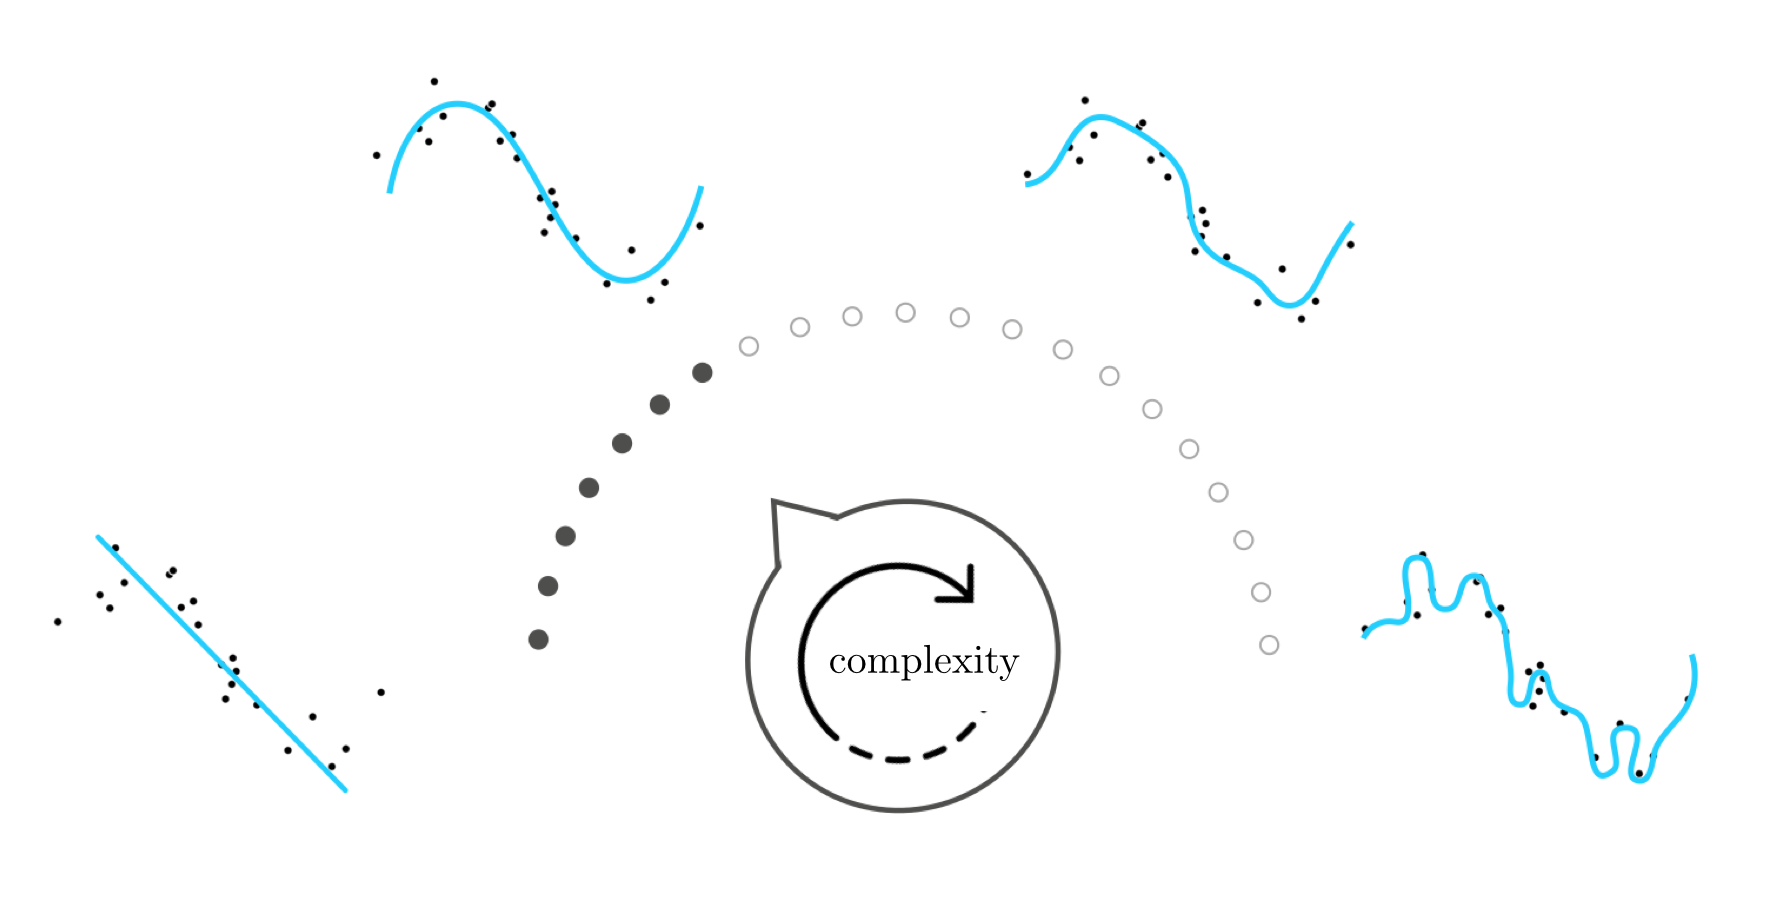

In [3]:
Image(image_path_2)

<a id='figure-11-2'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.2 </strong> <em> 
A visual depiction of feature learning as the \emph{construction} and *automatic* setting of a 'complexity dial' that - broadly speaking - controls the form the nonlinear model in Equation (1) as well as its parameter tuning, and thus the complexity of the model with respect to the training data.   While the complexity dial is a simplified depiction of feature learning we will see that it is nonetheless a helpful metaphor, as it can help us organize our understanding of the diverse set of ideas involved in it properly.
</em>
</figcaption>
</figure>

---